Assignment 1:

Name: Hongyang Du  

UID: 118314730

Please submit to Gradescope
- a PDF containing all outputs (by executing **Run all**)
- your ipynb notebook containing all the code

I understand the policy on academic integraty (collaboration and the use of online material).
Please sign your name here: 118314730


# Part A: Hybrid Image (25 Points)

## Overview

A hybrid image is the sum of a *low-pass filtered* version of the one image and a *high-pass filtered* version of a second image. There is a free parameter, which can be tuned for each image pair, which controls how much high frequency to remove from the first image and how much low frequency to leave in the second image. This is called the “cutoff-frequency”. In the paper it is suggested to use two cutoff frequencies (one tuned for each image) and you are free to try that, as well. In the starter code, the cutoff frequency is controlled by changing the standard deviation of the Gausian filter used in constructing the hybrid images. [This](https://drive.google.com/uc?id=187FjBJLwnYXhylx08Vdh1SAA3AO-imYv) is the sample example.

NOTE:

1. Reading [this](https://stanford.edu/class/ee367/reading/OlivaTorralb_Hybrid_Siggraph06.pdf) will help in understanding Part A.

2. You can use any image processing libraries of your choice such as skimage or cv2; in python.

We provided 7 pairs of aligned images. The alignment is important because it affects the perceptual grouping (read the paper for details). We encourage you to create additional examples (e.g. change of expression, morph between different objects, change over time, etc.).

You are required to provide **THREE hybrid image results**. Choose ONE of the results, and use it to provide answers to the following **FOUR sub-parts** mentioned in the write-up.

# Dependencies
```
pip3 install opencv-python numpy pillow matplotlib gdown
```

## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [50]:
# Download Data -- run this cell only one time per runtime
# !gdown 1KTDxPAkQam29YKtoX5dKPnLKpUOWCanC
# !unzip "/content/hybrid_pyramid_input.zip" -d "/content/"

## Code

In [51]:
# Helper Functions
def normalize(image):
    """
    normalize an image so it wouldn't overflow
    """
    return (image - np.min(image)) / np.max((image - np.min(image))) 


def read_image(image_path):
    """
    :param image_path: path to the image
    :return: floating representation of the image
    """
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    image_floating = image.astype('float32')/255.0
    return image_floating

def gaussian_2D_filter(size, cutoff_frequency):
    """
    :param size: tuple (width, height) that decides the filter size
    :param cutoff_frequency: hyperparameter to control the variance of the filter
    :return: 2D gaussian filter with the desired size, and variance scaled by cutoff_frequency
    Hint: make sure the filter sums up to one
    Do NOT use scipy's API to get the filter. Please just use numpy to implement the Gaussian equation.
    """
    m, n = size
    x, y = np.meshgrid(np.linspace(-n//2, n//2, n), np.linspace(-m//2, m//2, m))
    filter = np.exp(-(x**2 + y**2) / (2 * cutoff_frequency**2)) / (2 * np.pi * cutoff_frequency**2)
    filter /= filter.sum()
    return filter

def imgfilter(image, filter):
    """
    :param image: input image to apply the filter on
    :param filter: to apply on the image
    :return: apply the filter by convolving
    Do NOT use for loops. See how to convolve with scipy or numpy
    """
    output = np.zeros_like(image)
    if len(image.shape) == 3: 
        for i in range(image.shape[2]):
            output[:, : , i] = convolve2d(image[:, :, i], filter, mode='same', boundary='fill', fillvalue=0)
    else:
        output = convolve2d(image,filter, mode='same', boundary='fill', fillvalue=0)
            
    return output

def log_mag_FFT(image):
    """
    :param image: float matrix representation of the image
    :return: log of the magnitude of the FFT of the image
    HINT: You may use np.log(np.abs(np.fft.fftshift(np.fft.fft2(image)))) to achieve it.
    NOTE1: numpy fft2 would require you to convert the image to greyscale for it to work properly.
    NOTE2: To make greyscale, you may use either `grey = R*0.3 + G*0.59 + B*0.11` or `cv2.cvtColor`.
    """
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    output = np.log(np.abs(np.fft.fftshift(np.fft.fft2(gray))))
    return output

def vis_hybrid_image(hybrid_image):
  scales = 5
  scale_factor = 0.5
  padding = 5
  original_height = hybrid_image.shape[0]
  num_colors = hybrid_image.shape[2] # counting how many color channels the input has
  output = hybrid_image
  cur_image = hybrid_image

  for i in range(2, scales):
      # add padding
      output = np.concatenate((output, np.ones((original_height, padding, num_colors), dtype=int)), axis=1)      
      # dowsample image;
      width = int(cur_image.shape[1] * scale_factor)
      height = int(cur_image.shape[0] * scale_factor)
      dim = (width, height)
      cur_image = cv2.resize(cur_image, dim, interpolation = cv2.INTER_LINEAR)
      # pad the top and append to the output
      tmp = np.concatenate((np.ones((original_height-cur_image.shape[0], cur_image.shape[1], num_colors)), cur_image), axis=0)
      output = np.concatenate((output, tmp), axis=1)
  
  output = (output * 255).astype(np.uint8)
  return output

In [52]:
# Import necessary packages here
import cv2
import numpy as np
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
# the images downloaded above should be available under /content/data
# use the file directory on the left to navigate
def generate_hybrid(path1,path2,display = False):
  image_path2 = path1  # TODO choose the first image
  image_path1 = path2   # TODO choose the second image

  image_1 = read_image(image_path1)
  image_2 = read_image(image_path2)

# NOTE: the two images should have the same shape

  # YOUR CODE HERE: TUNE cutoff_frequency
  cutoff_frequency = 7
  filter_size = cutoff_frequency*4+1
  """cutoff_frequency is the standard deviation, in pixels, of the
  Gaussian blur that will remove the high frequencies from one image (image_1) and
  remove the low frequencies from another image (image_2) (to do so, subtract a blurred
  version from the original version). You will want to tune this for every image pair to get the best results."""

  filter = gaussian_2D_filter((filter_size, filter_size), cutoff_frequency)
  if display:
    plt.imshow(filter)

  """Use imgfilter() to create 'low_frequencies' and 'high_frequencies' and then combine them to create 'hybrid_image'.
  Remove the high frequencies from image_1 by blurring it. The amount of blur that works best will vary with different image pairs."""

  blurred_image1 = imgfilter(image_1, filter=filter)
  blurred_image2 = imgfilter(image_2, filter=filter)

  # YOUR CODE HERE.
  low_frequencies = blurred_image1

  """Remove the low frequencies from image_2. The easiest way to do this is to
  subtract a blurred version of image_2 from the original version of image_2.
  This will give you an image centered at zero with negative values."""

  # YOUR CODE HERE
  high_frequencies = image_2 - blurred_image2

  """Combine the high frequencies and low frequencies to obtain hybrid_image."""
  # YOUR CODE HERE
  hybrid_image =   low_frequencies +  high_frequencies

  """Firstly, visualize image_1, low_frequencies of image_1, image_2, high_frequencies of image_2, and the hybrid image."""
  # YOUR CODE HERE.
  # hint: you may use plt.subplots and add title to each subplot

  if display:
    fig, axs = plt.subplots(1, 5, figsize=(15, 10))

    axs[0].imshow(image_1, cmap='gray')
    axs[0].set_title('Image 1')

    axs[1].imshow(low_frequencies, cmap='gray')
    axs[1].set_title('Low Frequencies of Image 1')

    axs[2].imshow(image_2, cmap='gray')
    axs[2].set_title('Image 2')

    enhanced_high_frequencies = 10 * high_frequencies
    axs[3].imshow(enhanced_high_frequencies, cmap='gray')
    axs[3].set_title('High Frequencies of Image 2')

    axs[4].imshow(hybrid_image, cmap='gray')
    axs[4].set_title('Hybrid Image')
    plt.show()

  
    """Secondly, also visualize log magnitude of Fourier Transform of the above."""
    # FFT_image = 
    # YOUR CODE HERE.
    # hint: implement and use the helper function above `log_mag_FFT()`
    # hint: In plt's `imshow()`, you can set the `vmin` and `vmax` to have a proper range to visualize Fourier magnitude.
    fig, axs = plt.subplots(1, 5, figsize=(15, 10))

    FFT_image1 = log_mag_FFT(image_1)
    FFT_low_frequencies = log_mag_FFT(low_frequencies)
    FFT_image2 = log_mag_FFT(image_2)
    FFT_high_frequencies = log_mag_FFT(high_frequencies)
    FFT_hybrid_image = log_mag_FFT(hybrid_image)
    axs[0].imshow(FFT_image1, cmap='gray')
    axs[0].set_title('FFT Image 1')

    axs[1].imshow(FFT_low_frequencies, cmap='gray')
    axs[1].set_title('FFT Low Frequencies of Image 1')

    axs[2].imshow(FFT_image2, cmap='gray')
    axs[2].set_title('FFT Image 2')

    axs[3].imshow(FFT_high_frequencies, cmap='gray')
    axs[3].set_title(' FFT High Frequencies of Image 2')

    axs[4].imshow(FFT_hybrid_image, cmap='gray')
    axs[4].set_title('FFT Hybrid Image')

    plt.tight_layout()
    plt.show()

    """Thirdly, visualize hybrid_image_scale using helper function `vis_hybrid_image()`.
      Lastly, save all your outputs."""
    hybrid_image_scale = vis_hybrid_image(normalize(hybrid_image))
    plt.figure(figsize=(20, 10))
    plt.imshow(hybrid_image_scale)
    plt.title('Hybrid Image at Different Scales')
    plt.show()

  else:
    plt.imshow(normalize(hybrid_image))
    plt.show()


  #plt.imsave('hybrid_image.jpg', normalize(hybrid_image), cmap='gray', format='jpg')

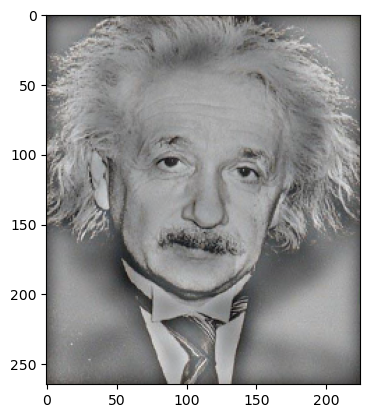

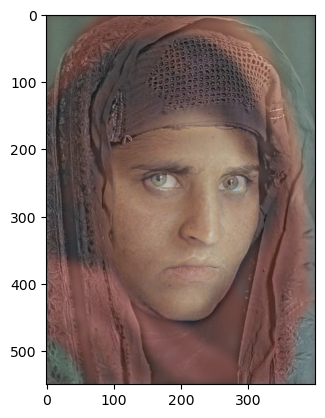

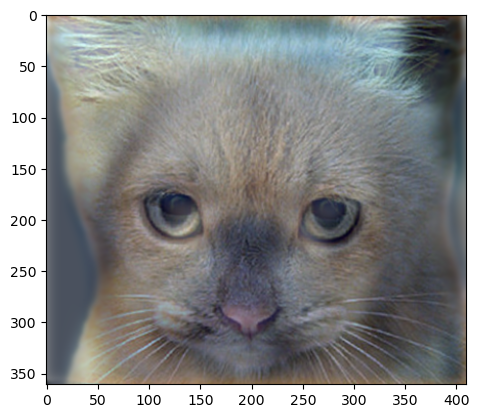

In [53]:
generate_hybrid('data/einstein.bmp','data/marilyn.bmp')
generate_hybrid('data/Afghan_girl_after.jpg','data/Afghan_girl_before.jpg')
generate_hybrid('data/cat.bmp','data/dog.bmp')

## **Write-up**


1.   Provide the original and filtered images.
2.   Provide the the hybrid image and hybrid_image_scale using given helper function *vis_hybrid_image*.
3.   Log magnitude of the Fourier transform of the two original images, the filtered images, and the hybrid image.
4.   Briefly explain how this works, using your favorite results as illustrations.

**Include your write-up here**

#### I used cat.bmp and dog.bmp as two original picutres. To mix them, I retrieved the low frequency part of the dog by applying gaussian filter to it. Then I retrieved high frequency part by substract the original cat picture to the gaussian filter applied cat (low frequency part). Then I combined them by adding the low freqency and high frequency parts. Some of the pixels overflow so I normailized it for better visual representation.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


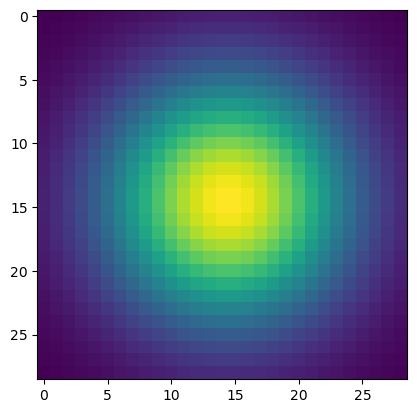

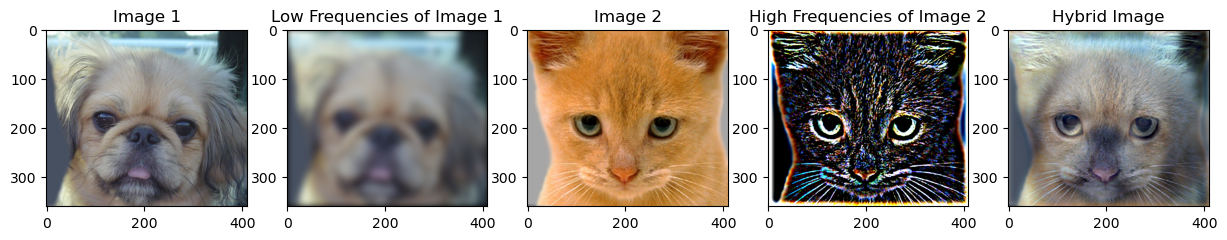

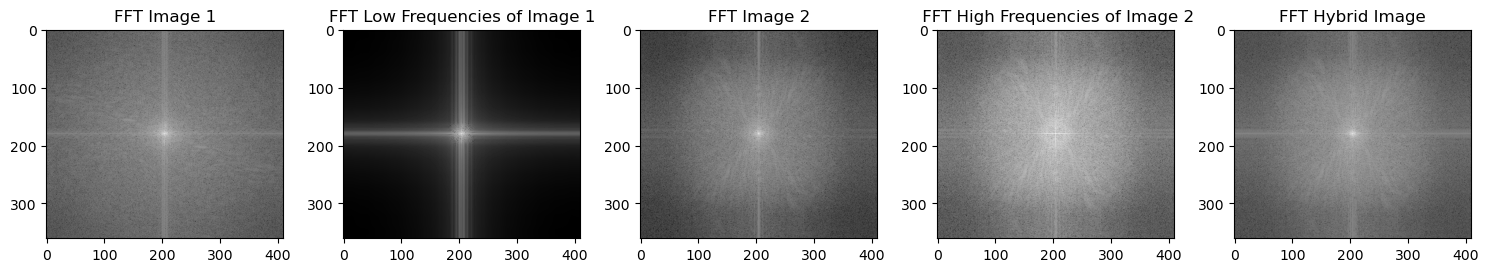

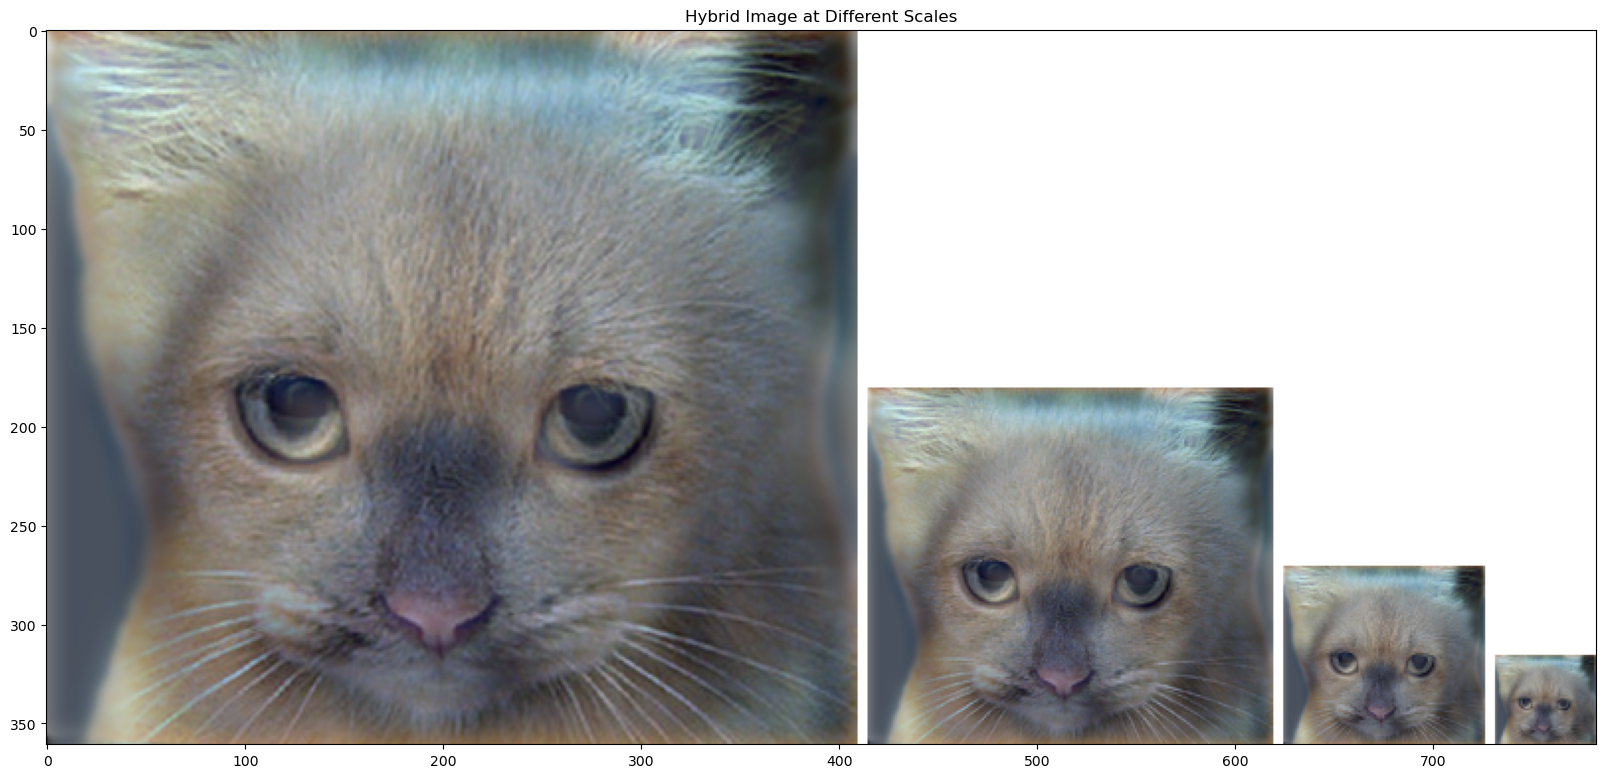

In [54]:
generate_hybrid('data/cat.bmp','data/dog.bmp',True)

# Part B: Pyramid Image (25 Points)

## Overview
Choose an image that has interesting variety of textures (from Flickr or your own images). The images should be atleast 640X480 pixels and converted to grayscale. Write code for a Gaussian and Laplacian pyramid of level N (use for loops). In each level, the resolution should be reduced by a factor of 2. Show the pyramids for your chosen image in your write-up. Here is an [example](https://drive.google.com/uc?id=17Y287EA-GJ2z0wtm_M7StIWsXyFeHvrz).

## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [55]:
# Download Data -- run this cell only one time per runtime
# !gdown 1KTDxPAkQam29YKtoX5dKPnLKpUOWCanC
# !unzip "/content/hybrid_pyramid_input.zip" -d "/content/"

## Code

In [60]:
# Populate Helper Functions:

def pyramidsGL(image, num_levels):
  ''' Creates Gaussian (G) and Laplacian (L) pyramids of level "num_levels" from image im.
  G and L are list where G[i], L[i] stores the i-th level of Gaussian and Laplacian pyramid, respectively. 
  NOTE: you may use cv2.GaussianBlur and cv2.resize in this function'''
  G = [image]

  for i in range(num_levels - 1):
    blurred = cv2.GaussianBlur(G[i], (5, 5), 0) 
    downsampled = cv2.resize(blurred, (G[i].shape[1] // 2, G[i].shape[0] // 2))
    G.append(downsampled)
    
  L = [G[-1]] 
  for i in range(num_levels - 1, 0, -1):
      upsampled = cv2.resize(G[i], (G[i-1].shape[1], G[i-1].shape[0]))
      laplacian_level = cv2.subtract(G[i-1], upsampled)
      L.insert(0, normalize(laplacian_level))

  return G, L

def displayPyramids(G, L):
  '''Role of this function is to display intensity and Fast Fourier Transform (FFT) images of pyramids.
  NOTE: You may re-use your helper function  "log_mag_FFT" to compute this.'''
  
  fig, axs = plt.subplots(2, len(G), figsize=(15, 10))
  for i in range(len(G)):
    axs[0, i].imshow(G[i], cmap='gray')
    axs[0, i].set_title('Gaussian Level' + str(i))

    axs[1, i].imshow(log_mag_FFT(G[i]), cmap='gray')
    axs[1, i].set_title('FFT Gaussian Level' + str(i))
  plt.tight_layout()
  plt.show()

  fig, axs = plt.subplots(2, len(L), figsize=(15, 10))
  for i in range(len(L)):
    axs[0, i].imshow(L[i], cmap='gray')
    axs[0, i].set_title('Laplacian Level' + str(i))

    axs[1, i].imshow(log_mag_FFT(L[i]), cmap='gray')
    axs[1, i].set_title('FFT Laplacian Level' + str(i))
  plt.tight_layout()
  plt.show()
    
  return
def reconstructLaplacianPyramid(L, smallest_g):
    '''Given a Laplacian Pyramid L, reconstruct an image img.
    smallest_g should be the smallest scale of the gaussian pyramid (i.e. G[-1])
    NOTE: you may use cv2.resize in this function
    '''
    assert L[-1].shape == smallest_g.shape, "The shape of the smallest Gaussian level and the last Laplacian level must match."
    
    current_img = smallest_g  
    for i in range(len(L)-1, -1, -1):  #
        upsampled = cv2.resize(current_img, (L[i].shape[1], L[i].shape[0]))  
        current_img = cv2.add(upsampled, L[i])  
    return normalize(current_img)


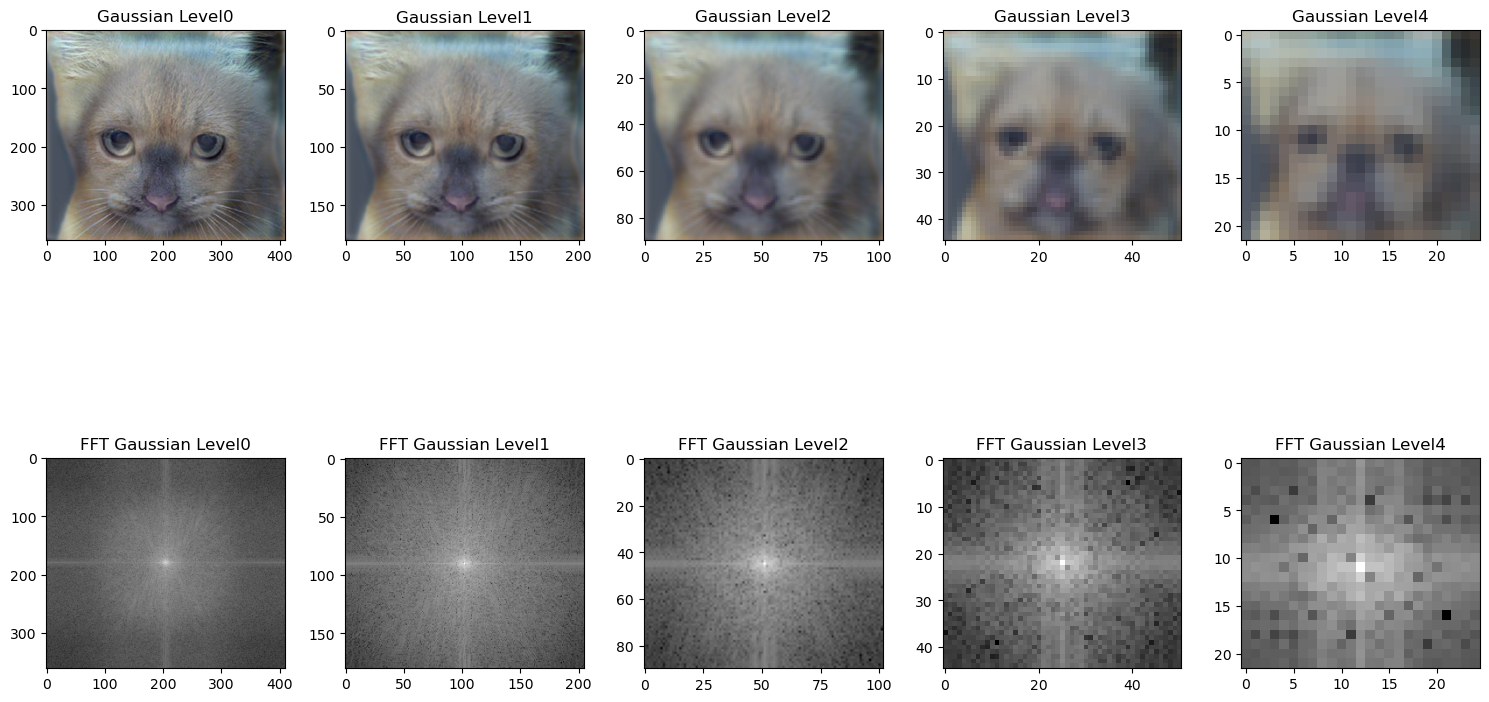

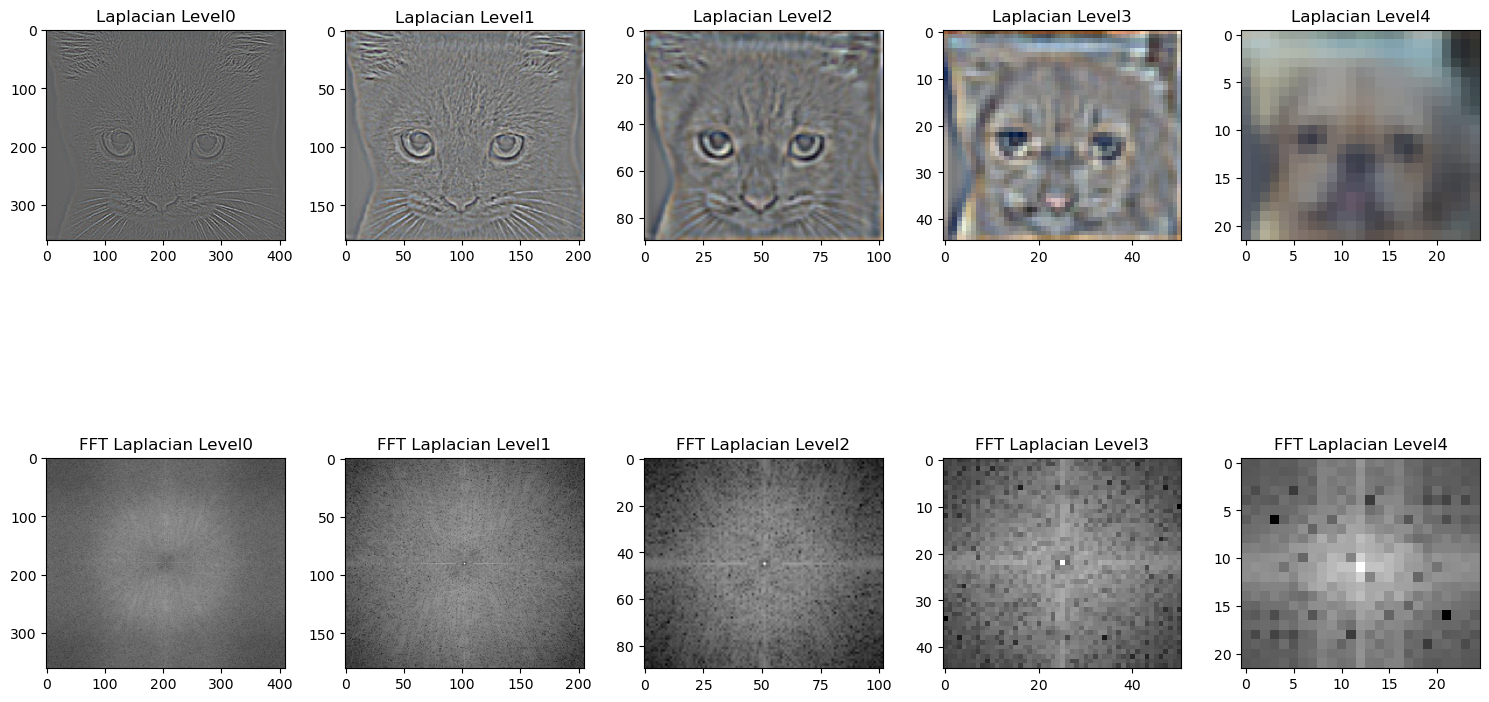

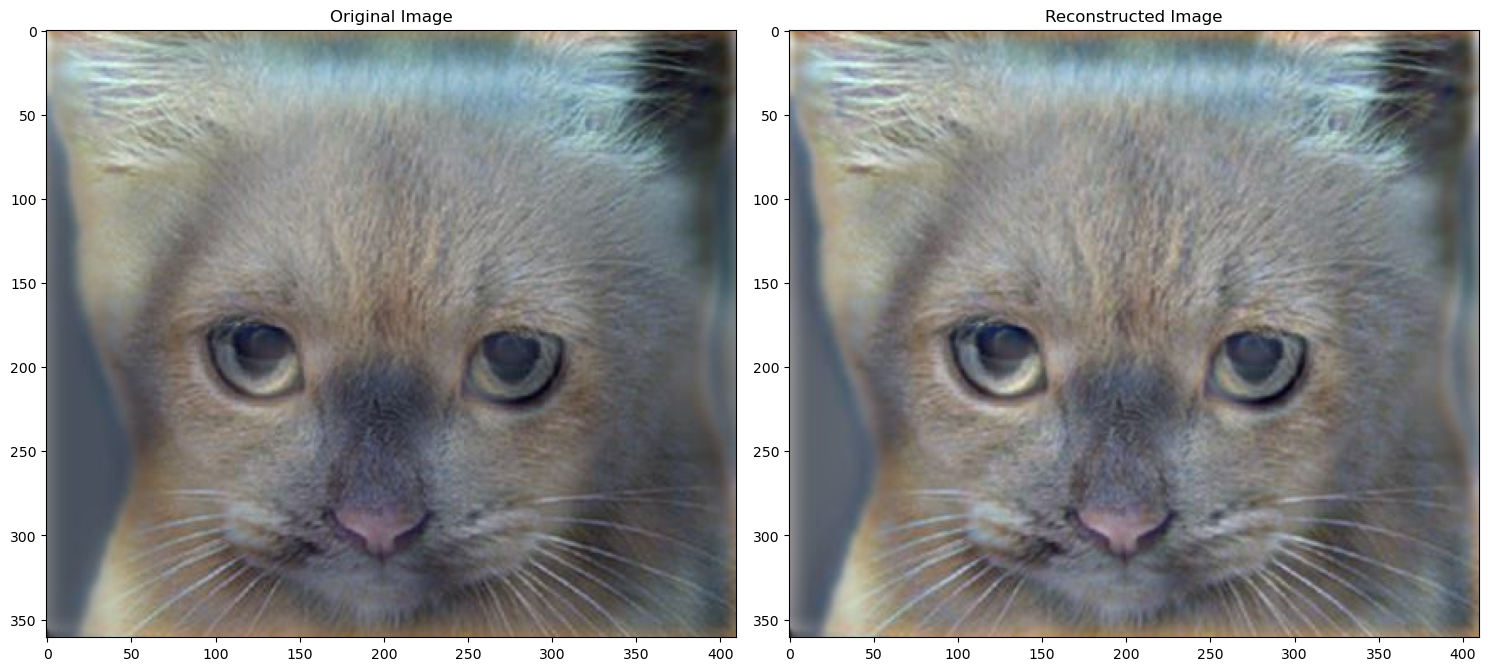

In [61]:
"""
Steps:
1. Load an image im.
2. Call function pyramidsGL with image and num_levels = 5
3. Call function displayPyramids with G, L
4. Call function reconstructLaplacianPyramid with the generated L and ONLY the smallest scale of G.
5. Display the original image and reconstructed image side by side.
6. Compute reconstruction error with L2 norm and print the error value.
"""


image_path = 'hybrid_image.jpg'
image = read_image(image_path)

G,L = pyramidsGL(image, 5)
displayPyramids(G,L)

reconstructed_image = reconstructLaplacianPyramid(L, G[-1])

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(image, cmap='gray')
axs[0].set_title('Original Image')
axs[1].imshow(reconstructed_image, cmap='gray')
axs[1].set_title('Reconstructed Image')

plt.tight_layout()
plt.show()


## **Write-up**

1. (10 Points) Display a Gaussian and Laplacian pyramid of level 5 (using your code). It should be formatted similar to [this](https://drive.google.com/file/d/1mAommQeJsp7WS8QCrZRcr8cQiltPPOh2/view?usp=sharing) figure.

2. (10 Points) Display the FFT amplitudes of your Gaussian/Laplacian pyramids Appropriate display ranges (from 0 to 1) should be chosen so that the changes in frequency in different levels of the pyramid are clearly visible. Explain  what the Laplacian and Gaussian pyramids are doing in terms of frequency. [This](https://drive.google.com/file/d/1BqTPKq6Mqqxl5jNNPkvx4JOA5MRgVq08/view?usp=sharing) looks like the expected output.

3. (5 Points) Image Reconstruction


**Include your write-up here**

#### Gaussian pyramid is applaying Gaussian filter and downsample the image to lower frequency at each level. Laplacian pyramid retrieve the difference between successive Gaussian levels which is the lost frequency and detailed in each process in the Gaussian pyramid

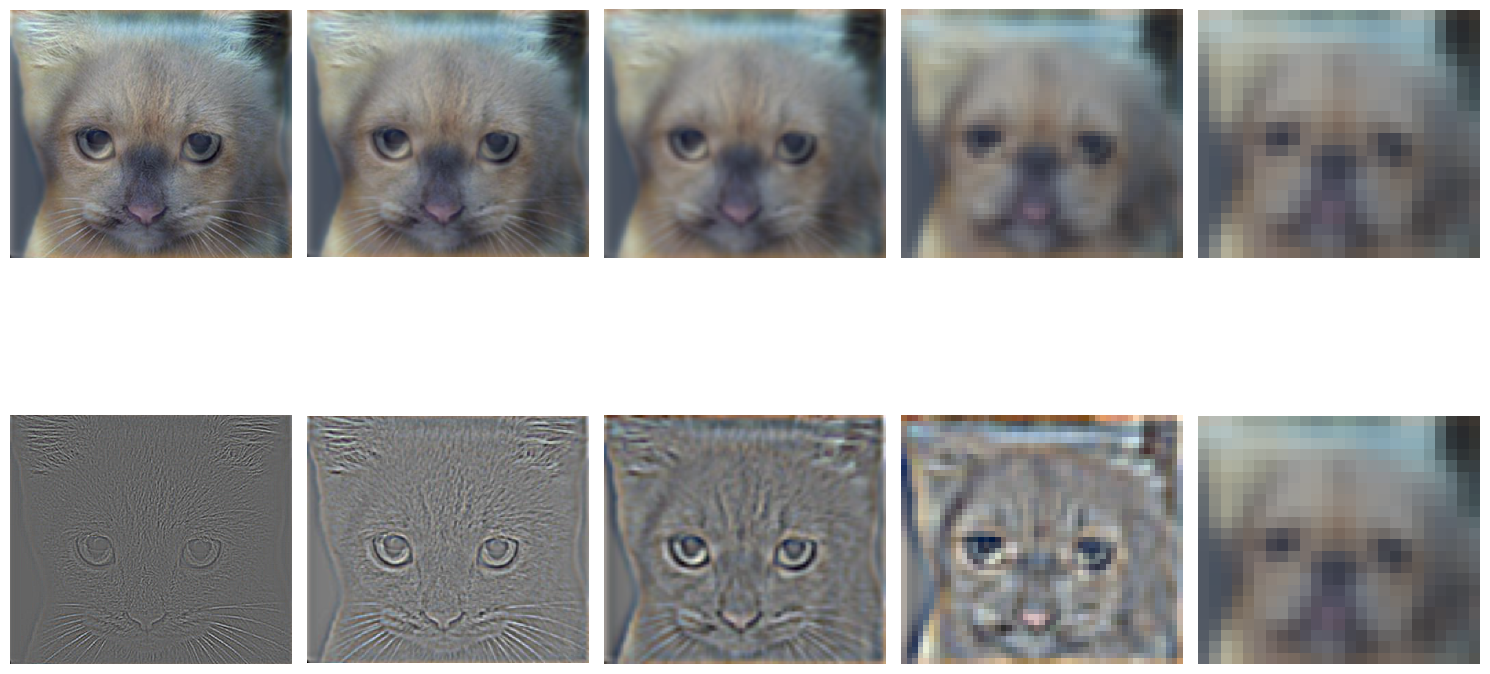

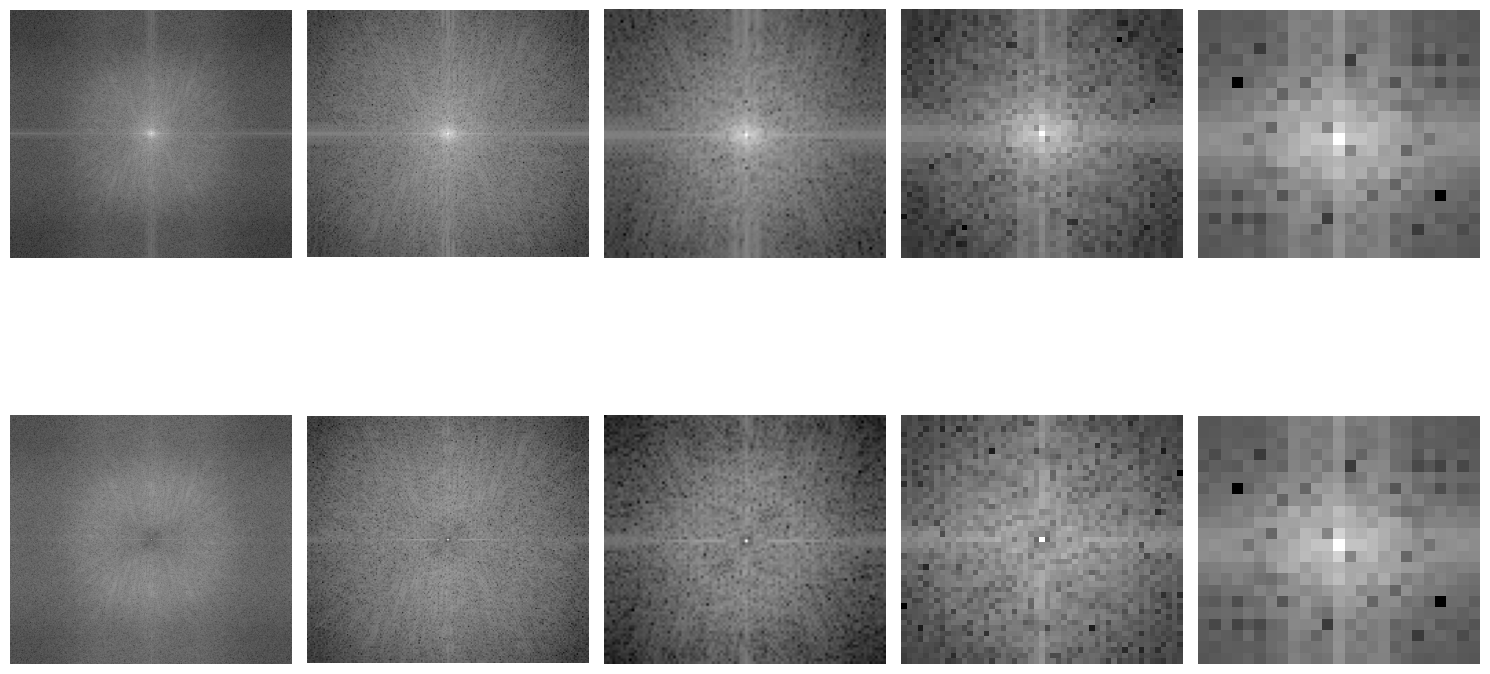

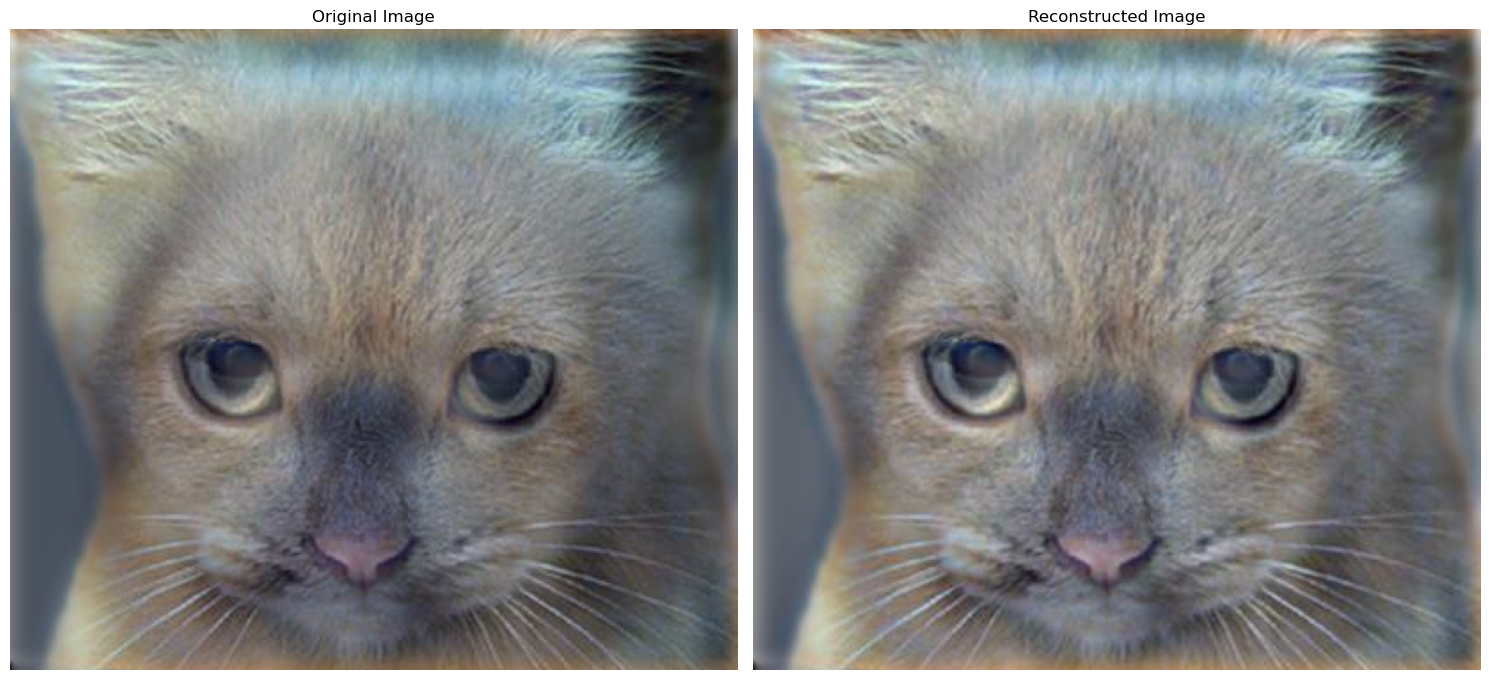

In [77]:
fig, axs = plt.subplots(2, len(G), figsize=(15, 10))
for i in range(len(G)):
    axs[0, i].imshow(G[i], cmap='gray')
    axs[0, i].axis('off')  
    axs[1, i].imshow(L[i], cmap='gray')
    axs[1, i].axis('off')
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(2, len(L), figsize=(15, 10))
for i in range(len(L)):
    axs[0, i].imshow(log_mag_FFT(G[i]), cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].imshow(log_mag_FFT(L[i]), cmap='gray')
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(image, cmap='gray')
axs[0].axis('off') 
axs[0].set_title('Original Image')
axs[1].imshow(reconstructed_image, cmap='gray')
axs[1].axis('off') 
axs[1].set_title('Reconstructed Image')

plt.tight_layout()
plt.show()